# We shall now proceed to split the cleaned images in the temp_dataset/training_set directory into train, test & validation sets to be created under the original dataset directory.

In [30]:
# import system libraries
import os
import warnings
from pathlib import Path
import shutil

In [31]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Generation of dataframe to convert temp_dataset directory paths to images and image labels into its row

In [32]:
# traversing the temp_dataset image paths to form the dataframe to be used for the split operation.

# Function to convert dataset directory paths to images and image labels into a dataframe
def get_image_paths_labels(root_dir="temp_dataset"):
    # Get all image file paths
    image_dir = Path(root_dir)
    filepaths = list(image_dir.glob('**/*.*'))

    # Extract labels from folder names
    labels = [path.parent.name for path in filepaths]

    # Create a DataFrame
    imagedf = pd.DataFrame({"filepath": filepaths, "label": labels})
    return imagedf

# Call the function with temp_dataset
df_image = get_image_paths_labels()

In [33]:
df_image.shape

(22437, 2)

#### And split the dataframe

In [34]:
warnings.filterwarnings("ignore", category=UserWarning, message=".*NumPy version.*")

In [35]:
# import libraries for splitting dataframe 
from sklearn.model_selection import train_test_split

In [36]:
# first splitting into full_train_df and test_df in the ratio 80:20
full_train_df, test_df = train_test_split(
    df_image, 
    test_size=0.2, 
    stratify=df_image['label'], # to prevent class imbalance and keep original proportion of images in the classes at the split sets
    random_state=42
)

In [37]:
full_train_df.shape

(17949, 2)

In [38]:
# then we futher split the full_train_df in train_df and val_df again in the ratio 80:20
train_df, val_df = train_test_split(
    full_train_df, 
    test_size=0.25,  # 25% of 80% is 20% of the total dataset
    stratify=full_train_df['label'], # to prevent class imbalance and keep original proportion of images in the classes at the split sets
    random_state=42
)

In [39]:
train_df.shape, val_df.shape, test_df.shape

((13461, 2), (4488, 2), (4488, 2))

#### Save split image data to new directories (train, val, test) in the original dataset directory

In [40]:
# Save split image data to new directories (train, val, test) in the original dataset directory

# Source directory where the original images are located
source_dir = "temp_dataset/training_set"

# Function to save split data to new directories (train, val, test) in the `dataset` directory
def save_split_data(df, base_dir, split_name, source_dir):
    # Create the target split directory (e.g., dataset/train, dataset/val, dataset/test)
    split_dir = Path(base_dir) / split_name
    split_dir.mkdir(parents=True, exist_ok=True)
    
    # Iterate through each unique label (species) in the DataFrame
    for label in df['label'].unique():
        # Create a directory for each label inside the split directory
        label_dir = split_dir / label
        label_dir.mkdir(parents=True, exist_ok=True)
        
        # Get the file paths for the current label
        files_for_label = df[df['label'] == label]['filepath']
        
        # Copy each file from the source directory to the corresponding label directory
        for file in files_for_label:
            source_file = Path(source_dir) / file.relative_to(file.parents[1])  # Match original structure
            shutil.copy(source_file, label_dir)

# Save each split data into the `dataset` directory
save_split_data(train_df, "dataset", "train", source_dir)
save_split_data(val_df, "dataset", "val", source_dir)
save_split_data(test_df, "dataset", "test", source_dir)

#### Now we can delete the temp_dataset directory

In [ ]:
# Now it is time to remove the temp_dataset directory
!rm -rf temp_dataset

## Now let us proceed towards the training of our model with Transfer Learning 

In [12]:
# required for supressing warnings of Tensorflow
import warnings

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # suppress info, warnings but lets out errors
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')

In [13]:
# importing the actual libraries
import tensorflow as tf
from tensorflow import keras

In [14]:
from tensorflow.keras.preprocessing.image import load_img

In [15]:
# getting the pretrained Xception model associated requirements
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

In [16]:
# getting the actual Xception model
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

#### Seeding for exact reproducibility

In [17]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Reading data with ImageDataGenerator

In [18]:
# importing the ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
# Reading data with ImageDataGenerator
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    './dataset/train',
    target_size=(150, 150), #Training Xception on smaller images (150x150) for faster processing
    batch_size=32,
    seed=SEED
)

val_ds = val_gen.flow_from_directory(
    './dataset/val',
    target_size=(150, 150),
    batch_size=32,
    seed=SEED,
    shuffle=False
)

Found 13461 images belonging to 25 classes.
Found 4488 images belonging to 25 classes.


In [20]:
# check the image classes picked up by tensorflow
class_list = list(train_ds.class_indices.keys())
print(class_list)

['Asian Green Bee-Eater', 'Brown-Headed Barbet', 'Cattle Egret', 'Common Kingfisher', 'Common Myna', 'Common Rosefinch', 'Common Tailorbird', 'Coppersmith Barbet', 'Forest Wagtail', 'Gray Wagtail', 'Hoopoe', 'House Crow', 'Indian Grey Hornbill', 'Indian Peacock', 'Indian Pitta', 'Indian Roller', 'Jungle Babbler', 'Northern Lapwing', 'Red-Wattled Lapwing', 'Ruddy Shelduck', 'Rufous Treepie', 'Sarus Crane', 'White Wagtail', 'White-Breasted Kingfisher', 'White-Breasted Waterhen']


#### Model Architechture

In [21]:
# creating the base model
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

# freeze the base_model: convolutional layers won’t be updated during training.
base_model.trainable = False

# Input layer: Defines the shape of the input images
inputs = keras.Input(shape=(150, 150, 3))

# Pass the inputs through the base model
# keeps the pre-trained features from ImageNet intact, preventing them from being overwritten.Ensures the model runs in inference mode
base = base_model(inputs, training=False)

# Global Average Pooling layer: Reduces the feature maps to a single vector per image
vectors = keras.layers.GlobalAveragePooling2D()(base)

# Output layer: Dense layer with 25 units (one for each bird species in your dataset)
outputs = keras.layers.Dense(25)(vectors)

# Create the model by connecting the inputs to the outputs
model = keras.Model(inputs, outputs)

In [22]:
# setting up the optimizer
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# since this is a multiclass classification
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# compiling the model before training
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [23]:
# Summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 25)                51225     
                                                                 
Total params: 20912705 (79.78 MB)
Trainable params: 51225 (200.10 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


#### Training the Model

In [140]:
# collecting the information during model training in the history object
history = model.fit(train_ds, epochs=10, validation_data=val_ds) # we are running this for 10 epoch

Epoch 1/10
421/421 [==============================] - 230s 534ms/step - loss: 1.8643 - accuracy: 0.6569 - val_loss: 1.9246 - val_accuracy: 0.6903
Epoch 2/10
421/421 [==============================] - 224s 532ms/step - loss: 1.2627 - accuracy: 0.7621 - val_loss: 1.8312 - val_accuracy: 0.7322
Epoch 3/10
421/421 [==============================] - 211s 501ms/step - loss: 1.0595 - accuracy: 0.8026 - val_loss: 1.9796 - val_accuracy: 0.7371
Epoch 4/10
421/421 [==============================] - 214s 509ms/step - loss: 0.8396 - accuracy: 0.8347 - val_loss: 1.9943 - val_accuracy: 0.7464
Epoch 5/10
421/421 [==============================] - 236s 560ms/step - loss: 0.6917 - accuracy: 0.8554 - val_loss: 2.1642 - val_accuracy: 0.7482
Epoch 6/10
421/421 [==============================] - 229s 545ms/step - loss: 0.6353 - accuracy: 0.8667 - val_loss: 2.4979 - val_accuracy: 0.7371
Epoch 7/10
421/421 [==============================] - 214s 508ms/step - loss: 0.5698 - accuracy: 0.8810 - val_loss: 2.6200 -

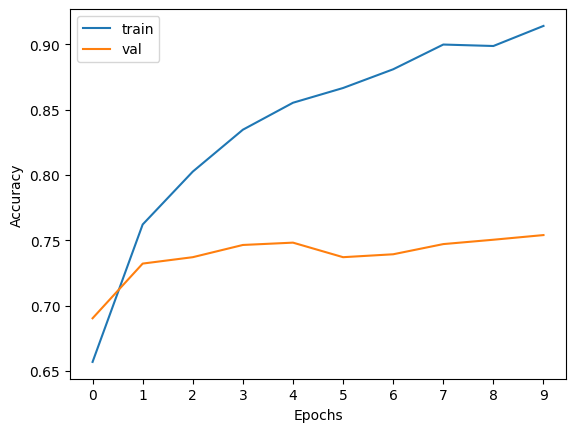

In [149]:
# plot the findings from the history object
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
# checking only for the validation accuracy
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

We see that the validation accuracy keeps rising with each epoch only to plummet after the 5th epoch and rise gain from the 6th and continues rising

#### Model Architechture for Training the Model - With learning rates

In [157]:
# function to create model with earning rate as paramenter
def create_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )
    
    base_model.trainable = False
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(25)(vectors)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
      
    return model

#### Tuning this Model - With adjusting learning rates

In [158]:
# initializing a dictionary to keep the histories against each learning rate
scores = {}
# running to check best learning_rate
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print('learning rate choosen is ', lr)

    model = create_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

learning rate choosen is  0.0001
Epoch 1/10
421/421 [==============================] - 639s 2s/step - loss: 2.0404 - accuracy: 0.4659 - val_loss: 1.3833 - val_accuracy: 0.6504
Epoch 2/10
421/421 [==============================] - 846s 2s/step - loss: 1.1981 - accuracy: 0.6855 - val_loss: 1.0829 - val_accuracy: 0.7028
Epoch 3/10
421/421 [==============================] - 844s 2s/step - loss: 0.9930 - accuracy: 0.7291 - val_loss: 0.9649 - val_accuracy: 0.7297
Epoch 4/10
421/421 [==============================] - 842s 2s/step - loss: 0.8893 - accuracy: 0.7527 - val_loss: 0.8980 - val_accuracy: 0.7429
Epoch 5/10
421/421 [==============================] - 280s 663ms/step - loss: 0.8216 - accuracy: 0.7702 - val_loss: 0.8560 - val_accuracy: 0.7533
Epoch 6/10
421/421 [==============================] - 218s 519ms/step - loss: 0.7722 - accuracy: 0.7823 - val_loss: 0.8273 - val_accuracy: 0.7594
Epoch 7/10
421/421 [==============================] - 230s 540ms/step - loss: 0.7322 - accuracy: 0.7930

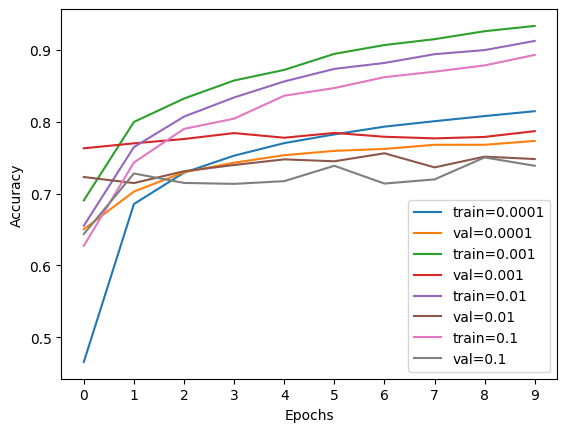

In [160]:
# plot the findings from the history object
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [161]:
# checking for the top two learning rates
del scores[0.1]
del scores[0.0001]

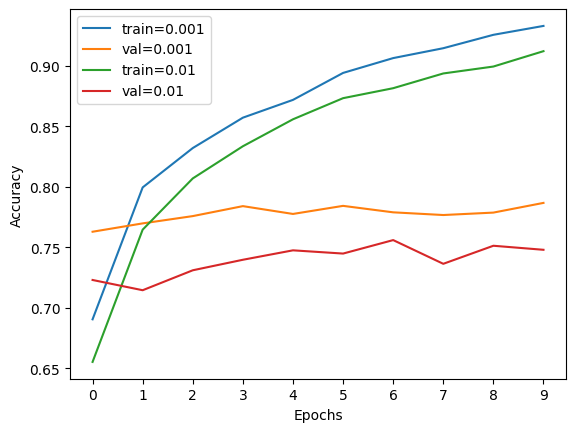

In [162]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

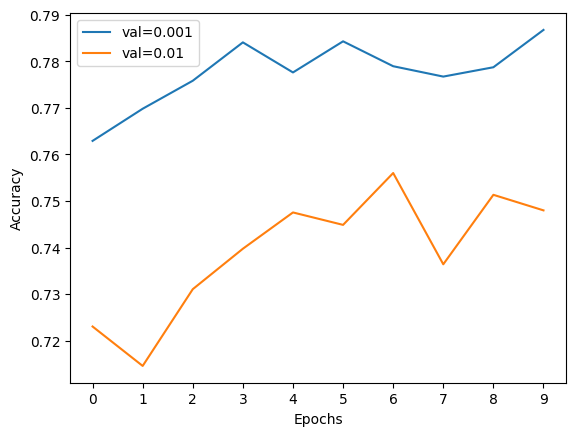

In [163]:
# checking only the validation accuracy
for lr, hist in scores.items():
 plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

So we can see that the best learning rate is 0.001 and the highest validation accuracy recorded with it in the history object is 0.7868. We shall use this score for comaparision in subsequent tuning and model architechture variation until a higher score is obtained.

In [24]:
#set the best selected learning_rate as global
learning_rate = 0.001

#### Model Architechture for Training the Model - With extra inner layer

In [167]:
# function to create model with extra inner layer
def create_model_with_extra_layer(learning_rate, size_inner):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    #add the extra inner layer
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(25)(inner)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

#### Tuning this Model - With adjusting size of the inner layer

In [168]:
# initializing a dictionary to keep the histories against each learning rate
scores_extra_layer = {}
# running to check best accuracy scores with various sizes of the extra
for size in [10, 100, 1000]:
    print('size of the extra inner layer ', size)

    model = create_model_with_extra_layer(learning_rate, size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores_extra_layer[size] = history.history

    print()
    print()

size of the extra inner layer  10
Epoch 1/10
421/421 [==============================] - 249s 585ms/step - loss: 2.1170 - accuracy: 0.4087 - val_loss: 1.4998 - val_accuracy: 0.5633
Epoch 2/10
421/421 [==============================] - 214s 507ms/step - loss: 1.3268 - accuracy: 0.6121 - val_loss: 1.2474 - val_accuracy: 0.6346
Epoch 3/10
421/421 [==============================] - 216s 513ms/step - loss: 1.1447 - accuracy: 0.6620 - val_loss: 1.1583 - val_accuracy: 0.6624
Epoch 4/10
421/421 [==============================] - 213s 506ms/step - loss: 1.0386 - accuracy: 0.6942 - val_loss: 1.1194 - val_accuracy: 0.6700
Epoch 5/10
421/421 [==============================] - 216s 513ms/step - loss: 0.9661 - accuracy: 0.7165 - val_loss: 1.0641 - val_accuracy: 0.6840
Epoch 6/10
421/421 [==============================] - 210s 498ms/step - loss: 0.9101 - accuracy: 0.7292 - val_loss: 1.0578 - val_accuracy: 0.6907
Epoch 7/10
421/421 [==============================] - 207s 492ms/step - loss: 0.8671 - acc

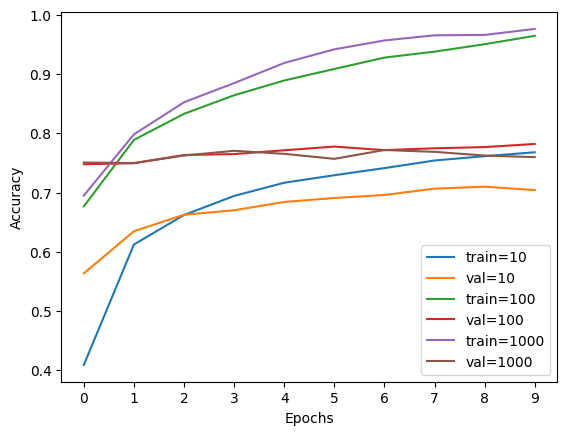

In [171]:
# plot the findings from the history object
for size, hist in scores_extra_layer.items():
    plt.plot(hist['accuracy'], label=('train=%s' % size))
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

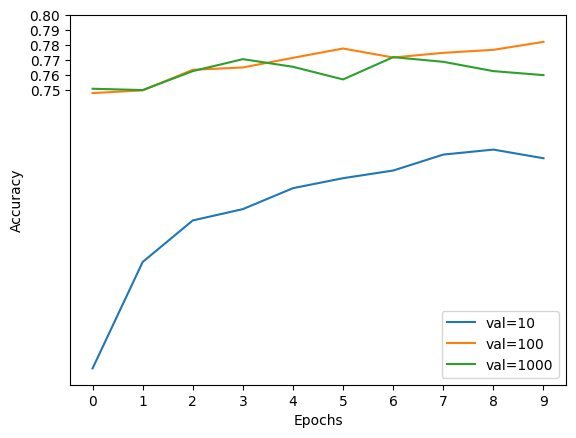

In [173]:
# plotting only for the validation accuracy
for size, hist in scores_extra_layer.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.yticks([0.75, 0.76, 0.77, 0.78, 0.79,0.80])
plt.legend()

We see that addition of extra inner layer does not seem to make any improvements over the previous recorded high score of 0.7868. However, it might improve over more epochs but I shall just leave this at 10 epochs. Anyways, the best scores among the 3 sizes of inner layers are from the size =100

#### Model Architechture for Training the model - with Dropout

For trying out dropout while training the model, we need to freeze a part (neuron) of the network in the inner layer. So we shall go with the addition of the inner layer with size = 100

In [27]:
# we shall take the best evaluated inner layer size from above
size = 100

In [28]:
# function to create model with dropout rate

def create_model_with_dropout(learning_rate, size_inner, droprate):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False
    
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    # setting dropout for the model training with droprate to the inner layer
   
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(25)(drop)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

#### Tuning this Model -with adjusting droprates

In [29]:
# training the model with different dropout rates
scores_dropout = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print('dropout rate is ', droprate)

    model = create_model_with_dropout(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores_dropout[droprate] = history.history

    print()
    print()

dropout rate is  0.0
Epoch 1/30
421/421 [==============================] - 229s 530ms/step - loss: 1.0911 - accuracy: 0.6806 - val_loss: 0.8359 - val_accuracy: 0.7473
Epoch 2/30
421/421 [==============================] - 214s 507ms/step - loss: 0.6815 - accuracy: 0.7929 - val_loss: 0.8046 - val_accuracy: 0.7667
Epoch 3/30
421/421 [==============================] - 219s 519ms/step - loss: 0.5344 - accuracy: 0.8347 - val_loss: 0.8164 - val_accuracy: 0.7625
Epoch 4/30
421/421 [==============================] - 204s 483ms/step - loss: 0.4377 - accuracy: 0.8638 - val_loss: 0.8067 - val_accuracy: 0.7701
Epoch 5/30
421/421 [==============================] - 205s 486ms/step - loss: 0.3565 - accuracy: 0.8898 - val_loss: 0.8487 - val_accuracy: 0.7736
Epoch 6/30
421/421 [==============================] - 206s 488ms/step - loss: 0.2939 - accuracy: 0.9081 - val_loss: 0.8546 - val_accuracy: 0.7741
Epoch 7/30
421/421 [==============================] - 204s 485ms/step - loss: 0.2386 - accuracy: 0.9273

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: './dataset/val/White Wagtail/ML393545651.jpg'
Traceback (most recent call last):

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: './dataset/val/White Wagtail/ML393545651.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[categorical_crossentropy/softmax_cross_entropy_with_logits/Shape_2/_6]]
  (1) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: './dataset/val/White Wagtail/ML393545651.jpg'
Traceback (most recent call last):

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/home/sidd4ml/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: './dataset/val/White Wagtail/ML393545651.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_252237]

In [ ]:
#plotting the findings from the history object
#for droprate, hist in scores_dropout.items():
#   plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

#plt.ylim(0.76, 0.79)
#plt.legend()

So we can see that the best validation accuracy is for the dropout rate = 0.5

In [62]:
droprate = 0.5

#### Training a larger model (299*299) with the best evaluated learing rate, inner layer input size and dropout rate

In [58]:
# create the model architechture for the larger model with best parameters

#for larger model
input_size = 299

def make_model_larger(input_size, learning_rate, size_inner, droprate):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(25)(drop)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [56]:
# loading the image references
train_ds = train_gen.flow_from_directory(
    './dataset/train',
    target_size=(input_size, input_size),
    batch_size=32,
    seed = SEED
)

val_ds = train_gen.flow_from_directory(
    './dataset/val',
    target_size=(input_size, input_size),
    batch_size=32,
    seed = SEED,
    shuffle=False
)

Found 13461 images belonging to 25 classes.
Found 4488 images belonging to 25 classes.


In [67]:
# checkpointing to save the best model
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v_final_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [68]:
# training the larger model
print('learning_rate is ', learning_rate)
print('size is ', size)
print('droprate is ', droprate)
print()
print()

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

#suppress warnings
warnings.filterwarnings('ignore', category=UserWarning, message=".*HDF5.*")

# we shall run for 20 epochs as we have seen best scores in the 16th epoch for the best evaluated droprate
history = model.fit(train_ds, epochs=20, validation_data=val_ds,
                   callbacks=[checkpoint])

learning_rate is  0.001
size is  100
droprate is  0.5


Epoch 1/20
421/421 [==============================] - 252s 592ms/step - loss: 0.9373 - accuracy: 0.7528 - val_loss: 0.2928 - val_accuracy: 0.9254
Epoch 2/20
421/421 [==============================] - 252s 597ms/step - loss: 0.4185 - accuracy: 0.8810 - val_loss: 0.2217 - val_accuracy: 0.9358
Epoch 3/20
421/421 [==============================] - 252s 598ms/step - loss: 0.3364 - accuracy: 0.9029 - val_loss: 0.1893 - val_accuracy: 0.9454
Epoch 4/20
421/421 [==============================] - 254s 603ms/step - loss: 0.2893 - accuracy: 0.9131 - val_loss: 0.1775 - val_accuracy: 0.9483
Epoch 5/20
421/421 [==============================] - 263s 620ms/step - loss: 0.2468 - accuracy: 0.9264 - val_loss: 0.1723 - val_accuracy: 0.9508
Epoch 6/20
421/421 [==============================] - 253s 601ms/step - loss: 0.2237 - accuracy: 0.9328 - val_loss: 0.1683 - val_accuracy: 0.9505
Epoch 7/20
421/421 [==============================] - 250s 593ms/ste

#### Loading the best model saved by checkpointing and evaluating on the unseen test data

In [70]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './dataset/test',
    target_size=(299, 299),
    batch_size=32,
    seed = SEED,
    shuffle=False
)

Found 4488 images belonging to 25 classes.


In [73]:
# loading the model
model = keras.models.load_model('xception_v_final_19_0.959.h5')

In [74]:
# evaluating the model on the unseen test data
model.evaluate(test_ds)

141/141 [==============================] - 60s 418ms/step - loss: 0.1935 - accuracy: 0.9508


[0.19350285828113556, 0.9507575631141663]

We see that the final model shows a high accuracy of 0.95 when evaluated on the unseen test data

#### Let us use this model on an image that is not present in our dataset 

In [75]:
! wget https://images.fineartamerica.com/images/artworkimages/medium/3/coppersmith-barbet-prerna-jain.jpg

--2025-01-14 00:28:29--  https://images.fineartamerica.com/images/artworkimages/medium/3/coppersmith-barbet-prerna-jain.jpg
Resolving images.fineartamerica.com (images.fineartamerica.com)... 52.222.144.38, 52.222.144.2, 52.222.144.12, ...
Connecting to images.fineartamerica.com (images.fineartamerica.com)|52.222.144.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494834 (483K) [image/jpeg]
Saving to: ‘coppersmith-barbet-prerna-jain.jpg’

coppersmith-barbet- 100%[===================>] 483.24K   498KB/s    in 1.0s    

2025-01-14 00:28:32 (498 KB/s) - ‘coppersmith-barbet-prerna-jain.jpg’ saved [494834/494834]



In [76]:
# set the path
path = 'coppersmith-barbet-prerna-jain.jpg'

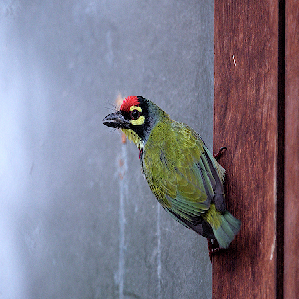

In [87]:
# loading the image
img = load_img(path, target_size=(299, 299))
img

In [79]:
# converting the image to array
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [80]:
# preprocessing the image
X = preprocess_input(X)

In [81]:
# predicting the image with the model
pred = model.predict(X)

1/1 [==============================] - 2s 2s/step


In [82]:
# remmember our class list above
class_list

['Asian Green Bee-Eater',
 'Brown-Headed Barbet',
 'Cattle Egret',
 'Common Kingfisher',
 'Common Myna',
 'Common Rosefinch',
 'Common Tailorbird',
 'Coppersmith Barbet',
 'Forest Wagtail',
 'Gray Wagtail',
 'Hoopoe',
 'House Crow',
 'Indian Grey Hornbill',
 'Indian Peacock',
 'Indian Pitta',
 'Indian Roller',
 'Jungle Babbler',
 'Northern Lapwing',
 'Red-Wattled Lapwing',
 'Ruddy Shelduck',
 'Rufous Treepie',
 'Sarus Crane',
 'White Wagtail',
 'White-Breasted Kingfisher',
 'White-Breasted Waterhen']

In [85]:
# predicted probabilites for each class
prediction_probabilites = dict(zip(class_list, pred[0]))
prediction_probabilites

{'Asian Green Bee-Eater': 0.23777412,
 'Brown-Headed Barbet': 0.17702368,
 'Cattle Egret': -15.3660755,
 'Common Kingfisher': -5.181986,
 'Common Myna': 0.9289235,
 'Common Rosefinch': -5.5548635,
 'Common Tailorbird': -6.0121703,
 'Coppersmith Barbet': 13.125159,
 'Forest Wagtail': -8.365479,
 'Gray Wagtail': -9.575635,
 'Hoopoe': -12.785848,
 'House Crow': -8.015687,
 'Indian Grey Hornbill': -11.037549,
 'Indian Peacock': -3.9352818,
 'Indian Pitta': -1.6187172,
 'Indian Roller': -5.3027253,
 'Jungle Babbler': -14.112219,
 'Northern Lapwing': -8.877903,
 'Red-Wattled Lapwing': -5.4971495,
 'Ruddy Shelduck': -14.568611,
 'Rufous Treepie': -6.8202763,
 'Sarus Crane': -6.3779984,
 'White Wagtail': -11.716781,
 'White-Breasted Kingfisher': -10.905071,
 'White-Breasted Waterhen': -12.93275}

In [86]:
# Get the class with the highest probability
max_class = max(prediction_probabilites, key=prediction_probabilites.get)

# Get the corresponding probability
max_probability = prediction_probabilites[max_class]

print(f"The class with the highest probability is '{max_class}' with a probability of {max_probability}")

The class with the highest probability is 'Coppersmith Barbet' with a probability of 13.12515926361084


#### And this indeed is a Coppersmit Barbet

## Thank you